In [1]:
import pandas as pd
import numpy as np

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
user_features=pd.read_csv('user_features.csv')

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)
user_features=reduce_mem_usage(user_features)


Memory usage after optimization is: 606.50 MB
Decreased by 62.5%
Memory usage after optimization is: 134.78 MB
Decreased by 50.0%
Memory usage after optimization is: 133.98 MB
Decreased by 84.8%


In [5]:
train_1=pd.merge(train, user_features, how='left', left_on='node1_id', right_on='node_id')

In [6]:
train_1=train_1.drop(['node_id'],axis=1)

In [7]:
train_2=pd.merge(train_1, user_features, how='left', left_on='node2_id', right_on='node_id')

In [8]:
del train,train_1
del test,user_features

In [9]:
train_2=train_2.drop(columns=['node_id','node1_id','node2_id'],axis=1)

In [10]:
# for i in range(1,14,1):
#     train_2['f_avg'+str(i)]=np.round((train_2['f'+str(i)+'_x']+train_2['f'+str(i)+'_y'])/2)

In [11]:
y_train=train_2['is_chat']

In [12]:
train_2=train_2.drop(['is_chat'],axis=1)

In [13]:
for col in train_2.columns:
    train_2[col]=train_2[col].astype('category')

In [14]:
train_2.head()

,f1_x,f2_x,f3_x,f4_x,f5_x,f6_x,f7_x,f8_x,f9_x,f10_x,...,f4_y,f5_y,f6_y,f7_y,f8_y,f9_y,f10_y,f11_y,f12_y,f13_y
0,22,0,0,24,0,0,24,0,0,26,...,15,11,5,19,12,5,16,10,4,10
1,0,0,0,0,0,0,0,0,0,0,...,16,13,6,20,16,7,25,21,6,15
2,9,2,0,14,7,1,14,7,1,14,...,1,1,0,1,1,0,0,0,0,8
3,11,11,10,11,10,9,10,9,8,7,...,1,1,1,1,1,1,1,1,1,15
4,31,31,31,31,31,31,31,31,31,31,...,7,1,0,9,1,0,16,1,0,7


In [15]:
# scale_pos_weight:

In [16]:
params_tuned = {
#     'bagging_freq': 5,
#    'bagging_fraction': 0.9,
#    'boost_from_average':'false',
    'boost': 'gbdt',
#     'feature_fraction': 0.05,
    'learning_rate': 0.15,
    'max_depth': -1,  
    'metric':'auc',
#    'min_data_in_leaf': 80,
#     'min_sum_hessian_in_leaf': 10.0,
#     'num_leaves': 13,
    'num_threads': -1,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    'num_leaves': 100,
    "device" : "gpu",
    "gpu_platform_id" : 0,
    "gpu_device_id" : 0,
    "scale_pos_weight":3
}

In [17]:
import time
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_valid, Y_train, Y_valid =train_test_split(train_2,y_train,test_size=0.2,stratify=y_train)

In [19]:
train_data = lgb.Dataset(X_train, label=Y_train,free_raw_data=False)
valid_data = lgb.Dataset(X_valid, label=Y_valid,free_raw_data=False)

In [20]:
import gc
gc.collect()

71

In [24]:
# callback
def save_model():
    def callback(env):
        model=env.model
        if env.iteration%100==0:
            model.save_model('./scale_folder/model_scale_'+str(env.iteration)+'.txt')
    callback.before_iteration = False
    callback.order = 0
    return callback

In [22]:
del X_train,Y_train,train_2,y_train

In [25]:
lgb_model = lgb.train(params_tuned,train_data,num_boost_round=10000,
                valid_sets = [valid_data],verbose_eval=100,early_stopping_rounds = 300,callbacks=[save_model()])

Training until validation scores don't improve for 300 rounds.
[100]	valid_0's auc: 0.850037
[200]	valid_0's auc: 0.851993
[300]	valid_0's auc: 0.853133
[400]	valid_0's auc: 0.853977
[500]	valid_0's auc: 0.854527
[600]	valid_0's auc: 0.854999
[700]	valid_0's auc: 0.855276
[800]	valid_0's auc: 0.855487
[900]	valid_0's auc: 0.855602
[1000]	valid_0's auc: 0.85576
[1100]	valid_0's auc: 0.855835
[1200]	valid_0's auc: 0.855915
[1300]	valid_0's auc: 0.856003
[1400]	valid_0's auc: 0.856005
[1500]	valid_0's auc: 0.85605
[1600]	valid_0's auc: 0.856061
[1700]	valid_0's auc: 0.85611
[1800]	valid_0's auc: 0.856113
[1900]	valid_0's auc: 0.856092
[2000]	valid_0's auc: 0.856113
[2100]	valid_0's auc: 0.856078
Early stopping, best iteration is:
[1807]	valid_0's auc: 0.85613


In [27]:
test=reduce_mem_usage(pd.read_csv('test.csv'))
ids=test.id

Memory usage after optimization is: 134.78 MB
Decreased by 50.0%


In [28]:
user_features=reduce_mem_usage(pd.read_csv('user_features.csv'))

Memory usage after optimization is: 133.98 MB
Decreased by 84.8%


In [29]:
test_1=pd.merge(test, user_features, how='left', left_on='node1_id', right_on='node_id')

In [30]:
test_1=test_1.drop(['node_id'],axis=1)

In [31]:
test_2=pd.merge(test_1, user_features, how='left', left_on='node2_id', right_on='node_id')

In [32]:
test_2=test_2.drop(['node1_id','node2_id'],axis=1)

In [33]:
test_2=test_2.drop(['id','node_id'],axis=1)

In [34]:
lgb_load=lgb.Booster(model_file='./scale_folder/model_scale_2100.txt')

In [35]:
lgb_model.best_iteration

1807

In [37]:
for col in test_2.columns:
    test_2[col]=test_2[col].astype('category')

In [38]:
test_preds=lgb_load.predict(test_2, num_iteration=1807)

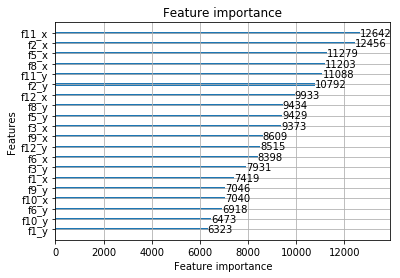

In [41]:
import matplotlib.pyplot as plt
lgb.plot_importance(lgb_load, max_num_features=20)
plt.show()

In [42]:
sub=pd.DataFrame()
sub['id']=ids
sub['is_chat']=test_preds
sub.to_csv('full_lgb_scale_preds.csv',index=False)
!zip full_lgb_scale_preds.zip full_lgb_scale_preds.csv

updating: full_lgb_scale_preds.csv (deflated 60%)
